# 360. IMDB Sentiment Analysis
- LSTM을 사용하여 IMDB 데이터 세트에 대한 감정 분석을 진행합니다.

- IMDB (Internet Movie Database, https://www.imdb.com/)  Dataset
    - 각 25,000 개의 training/testing set 으로 구성된 IMDB 영화관람평  

    - `imdb_reviews` – encoding 되어있지 않은 string 형태의 data  

    - label : positive, negative binary classification

In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

- 데이터 다운로드

In [2]:
!gdown 1RFs-jV18dy9I3cWQ2M80kHfON-fDCerg

Downloading...
From: https://drive.google.com/uc?id=1RFs-jV18dy9I3cWQ2M80kHfON-fDCerg
To: /content/IMDBDataset.csv
100% 66.2M/66.2M [00:01<00:00, 47.1MB/s]


In [3]:
df = pd.read_csv("IMDBDataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


- `sentiment`를 positive 1, negative 0 로 변경

In [4]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1. if x == 'positive' else 0.)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1.0
1,A wonderful little production. <br /><br />The...,1.0
2,I thought this was a wonderful way to spend ti...,1.0
3,Basically there's a family where a little boy ...,0.0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1.0


In [5]:
df['sentiment'].value_counts()

1.0    25000
0.0    25000
Name: sentiment, dtype: int64

### train / test set 분할

In [6]:
X = df['review'].values
y = df['sentiment'].values

train_sentences, test_sentences, train_labels, test_labels = \
                train_test_split(X, y, test_size=0.2, random_state=0)
                
train_sentences.shape, test_sentences.shape, train_labels.shape, test_labels.shape

((40000,), (10000,), (40000,), (10000,))

## keras.preprocessing module 을 이용하여 tokenize 및 padding
- keras.preprocessing.text.Tokenizer  
    - 문장을 tokenize

- keras.preprocessing.sequence.pad_sequence
    - 동일한 길이의 입력으로 truncate/pad

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000  #maximum number of words

tokenizer = Tokenizer(num_words = vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train_sentences)

- tokenizer의 dictionary를 이용하여 text 를 integer의 sequence로 변환

In [8]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

print(train_sentences[0])
print(train_sequences[0])

That's about the only redeeming quality in a movie that otherwise insults the viewer's intelligence by losing track of time, plot, and reason for being produced.<br /><br />Plus, how that guy with the glasses ever got a gig in Hollywood is beyond me.
[197, 42, 2, 62, 1713, 482, 9, 4, 18, 13, 885, 7196, 2, 6150, 1722, 32, 2350, 1379, 5, 57, 114, 3, 286, 17, 110, 1018, 8, 8, 923, 88, 13, 220, 16, 2, 4349, 123, 191, 4, 8165, 9, 373, 7, 682, 69]


- sentence length 분포 시각화

가장 긴 문장 길이 : 2493
평균 문장 길이 : 234.5575


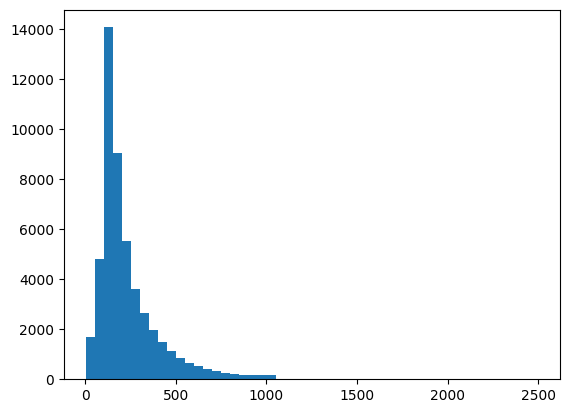

In [9]:
plt.hist([len(s) for s in train_sequences] + [len(s) for s in test_sequences], bins=50)

print('가장 긴 문장 길이 : {}'.format(max([len(s) for s in train_sequences])))
print('평균 문장 길이 : {}'.format(sum([len(s) for s in train_sequences])/len(train_sequences)))

### Padding
- 전체 sequence 를 동일한 길이로 통일

In [10]:
max_length = 300

train_padded = pad_sequences(train_sequences, maxlen=max_length, 
                             truncating='post', padding='post')

test_padded = pad_sequences(test_sequences, maxlen=max_length, 
                            truncating='post', padding='post')

print(train_padded.shape)
print(test_padded.shape)
print(train_padded[0])

(40000, 300)
(10000, 300)
[ 197   42    2   62 1713  482    9    4   18   13  885 7196    2 6150
 1722   32 2350 1379    5   57  114    3  286   17  110 1018    8    8
  923   88   13  220   16    2 4349  123  191    4 8165    9  373    7
  682   69    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 

- sequence data 를 sentence 로 reverse conversion 하여 sequence 변환이 잘 되었는지 확인

In [11]:
text = train_padded[0]
print(' '.join([tokenizer.index_word.get(i, '<pad>') for i in text]))
print()
print(train_sentences[0])

that's about the only redeeming quality in a movie that otherwise insults the viewer's intelligence by losing track of time plot and reason for being produced br br plus how that guy with the glasses ever got a gig in hollywood is beyond me <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

### `TensorDataset`을 이용하여 numpy sequence data 를 tensor dataloader 로 변환

In [12]:
# Tensor datasets 생성

train_data = TensorDataset(torch.LongTensor(train_padded), torch.FloatTensor(train_labels))
valid_data = TensorDataset(torch.LongTensor(test_padded), torch.FloatTensor(test_labels))

# dataloader 생성
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

In [13]:
# training data의 batch 한 개 출력
sample_X, sample_y =next(iter(train_loader))

print('Sample input size:', sample_X.size()) # batch_size, seq_length
print('Sample label size:', sample_y.size())

Sample input size: torch.Size([50, 300])
Sample label size: torch.Size([50])


### Model 생성

<img src="https://miro.medium.com/max/875/1*SICYykT7ybua1gVJDNlajw.png"  width=600 />

In [14]:
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, embedding_dim, 
                         hidden_dim, output_dim, drop_prob=0.3):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # 임베딩 레이어. 각 단어를 embedding_dim 차원의 벡터로 변환합니다.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM 레이어. 입력 차원(embedding_dim), hidden state 차원(hidden_dim)을 인자로 받습니다.
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim,
                        num_layers = no_layers, batch_first = True)
        
        # Dropout 레이어. 과적합을 방지하기 위해 사용합니다.
        self.dropout = nn.Dropout(drop_prob)

        # Fully-connected 레이어. LSTM의 hidden state를 입력으로 받아 output_dim 차원으로 출력합니다.
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Sigmoid 레이어. Binary classification 문제에서 출력을 확률로 해석할 수 있게 합니다.
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        # batch_size는 한 번에 처리하는 데이터의 양입니다.
        batch_size = x.size(0)
        
        # 입력 x를 임베딩 레이어에 통과시켜 임베딩 벡터를 얻습니다.
        embeds = self.embedding(x)  
        
        # 임베딩 벡터와 초기 hidden state를 LSTM에 통과시켜 새로운 hidden state를 얻습니다.
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        # batch_first를 True로 설정했기 때문에 lstm_out의 shape는 (batch_size, seq_length, hidden_dim)이 됩니다.
        lstm_out = lstm_out.reshape(batch_size, -1, self.hidden_dim) 

        # dropout 레이어를 통과시킵니다.
        out = self.dropout(lstm_out)
        
        # Fully-connected 레이어를 통과시킵니다.
        out = self.fc(out)     
    
        # 최종 출력을 위해 sigmoid 레이어를 통과시킵니다.
        sig_out = self.sig(out)
        
        # many-to-one 모델이므로 시퀀스의 마지막 출력만 반환합니다.
        return sig_out[:, -1], hidden
        
    def init_hidden(self, batch_size):
        ''' 초기 hidden state를 생성하는 함수 '''
        # h0, c0는 각각 초기 hidden state와 cell state를 의미합니다.
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        return (h0, c0)

In [15]:
no_layers = 1
vocab_size = vocab_size + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = SentimentRNN(no_layers, vocab_size, embedding_dim, 
                                  hidden_dim, output_dim, drop_prob=0.3)

model.to(device)

SentimentRNN(
  (embedding): Embedding(10001, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

### Training

In [16]:
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# accuracy 계산 helper function
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [17]:
import time
s = time.time()  # 시작 시간 저장
clip = 5  # 그래디언트 클리핑에 사용될 값
epochs = 10  # 전체 학습 반복 횟수
valid_loss_min = np.inf  # 검증 데이터에 대한 최소 손실값 초기화

LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []  # 손실과 정확도를 기록할 리스트 초기화

for epoch in range(epochs):  # 전체 데이터셋에 대한 학습을 epoch 횟수만큼 반복
    model.train()  # 모델을 학습 상태로 설정
    
    train_loss = 0  # 학습 데이터에 대한 손실 초기화
    train_acc = 0  # 학습 데이터에 대한 정확도 초기화
    for inputs, labels in train_loader:  # 학습 데이터셋에 대하여
        optimizer.zero_grad()  # 최적화 함수의 그래디언트 초기화

        inputs, labels = inputs.to(device), labels.to(device)   # 데이터와 레이블을 device로 이동 (GPU 사용 시 필요)
        
        h = model.init_hidden(batch_size)  # 히든 상태 초기화

        output, hidden = model(inputs, h)  # 모델의 순방향 패스 실행
        
        loss = criterion(output.squeeze(), labels)  # 손실 계산

        train_loss += loss.item()  # 배치에 대한 총 손실을 더함
        accuracy = acc(output, labels)  # 정확도 계산
        train_acc += accuracy  # 배치에 대한 총 정확도를 더함

        loss.backward()  # 역방향 패스 실행 (그래디언트 계산)
        nn.utils.clip_grad_norm_(model.parameters(), clip)  # 그래디언트 클리핑 (그래디언트 폭발 방지)
        optimizer.step()  # 가중치 업데이트

    train_loss = train_loss / len(train_data)  # 에폭에 대한 평균 학습 손실
    train_acc = train_acc / len(train_data)  # 에폭에 대한 평균 학습 정확도
    LOSS.append(train_loss)  # 학습 손실 기록
    ACC.append(train_acc)  # 학습 정확도 기록

    
    model.eval()  # 모델을 평가 상태로 설정

    val_loss = 0  # 검증 데이터에 대한 손실 초기화
    val_acc = 0  # 검증 데이터에 대한 정확도 초기화
    for inputs, labels in valid_loader:  # 검증 데이터셋에 대하여

        inputs, labels = inputs.to(device), labels.to(device)  # 데이터와 레이블을 device로 이동 (GPU 사용 시 필요)

        h = model.init_hidden(batch_size)  # 히든 상태 초기화
        
        output, hidden = model(inputs, h)  # 모델의 순방향 패스 실행

        loss = criterion(output.squeeze(), labels)  # 손실 계산

        val_loss +=  loss.item()  # 배치에 대한 총 손실을 더함
        
        accuracy = acc(output, labels)  # 정확도 계산
        val_acc += accuracy  # 배치에 대한 총 정확도를 더함

    val_loss = val_loss / len(valid_data)  # 에폭에 대한 평균 검증 손실
    val_acc = val_acc / len(valid_data)  # 에폭에 대한 평균 검증 정확도
    VAL_LOSS.append(val_loss)  # 검증 손실 기록
    VAL_ACC.append(val_acc)  # 검증 정확도 기록

    print(f'epoch {epoch} ==> train loss: {train_loss:.5f},  valididation loss: {val_loss:.5f}',  
                                            f'train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')  # 에폭마다 학습 손실, 검증 손실, 학습 정확도, 검증 정확도 출력
    
    if val_loss <= valid_loss_min:  # 만약 이 에폭의 검증 손실이 이전 최소 검증 손실보다 작다면
        torch.save(model.state_dict(), 'state_dict.pt')  # 모델의 상태를 저장
        print('model saved.............')  # 모델 저장 완료 메시지 출력
        valid_loss_min = val_loss  # 최소 검증 손실 업데이트

print((time.time() - s)/60)  # 전체 학습 시간 출력 (분 단위)

epoch 0 ==> train loss: 0.01389,  valididation loss: 0.01385 train acc: 0.50160, validation acc: 0.51430
model saved.............
epoch 1 ==> train loss: 0.01381,  valididation loss: 0.01379 train acc: 0.51428, validation acc: 0.52300
model saved.............
epoch 2 ==> train loss: 0.01362,  valididation loss: 0.01389 train acc: 0.53600, validation acc: 0.49660
epoch 3 ==> train loss: 0.01358,  valididation loss: 0.01389 train acc: 0.54260, validation acc: 0.52190
epoch 4 ==> train loss: 0.01166,  valididation loss: 0.01272 train acc: 0.70668, validation acc: 0.65140
model saved.............
epoch 5 ==> train loss: 0.00979,  valididation loss: 0.00906 train acc: 0.78705, validation acc: 0.80570
model saved.............
epoch 6 ==> train loss: 0.00737,  valididation loss: 0.00798 train acc: 0.84842, validation acc: 0.83940
model saved.............
epoch 7 ==> train loss: 0.00602,  valididation loss: 0.00760 train acc: 0.87628, validation acc: 0.84900
model saved.............
epoch 8 ==

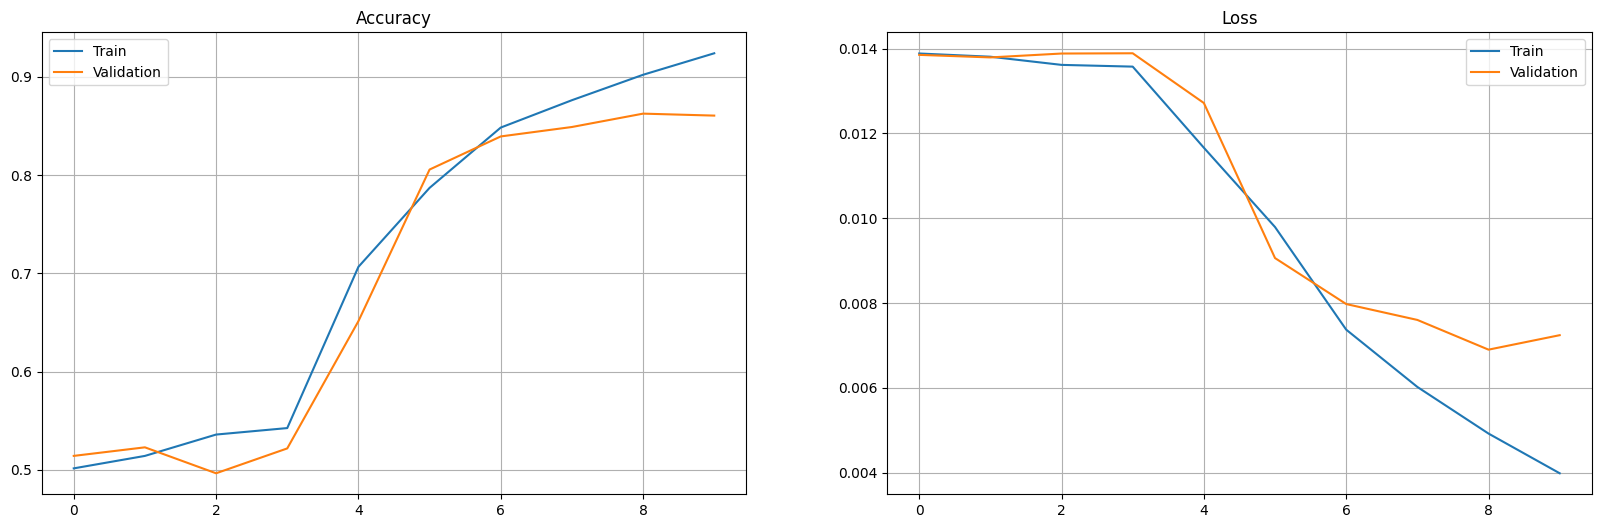

In [18]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(ACC, label='Train')
plt.plot(VAL_ACC, label='Validation')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(LOSS, label='Train')
plt.plot(VAL_LOSS, label='Validation')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

### Inferance

In [19]:
def predict_text(text):  # 텍스트에 대한 예측을 수행하는 함수 정의
    sequences = tokenizer.texts_to_sequences([text])  # 텍스트를 시퀀스로 변환
    padded = pad_sequences(sequences, maxlen=max_length, 
                            truncating='post', padding='post')  # 시퀀스를 동일한 길이로 패딩
    inputs = torch.tensor(padded).to(device)  # 패딩된 시퀀스를 텐서로 변환하고, 장치에 할당 (GPU 사용 시 필요)
    h = model.init_hidden(1)  # 히든 상태 초기화
    output, hidden = model(inputs, h)  # 모델의 순방향 패스를 실행하여 출력값과 히든 상태 얻음
    return output.item()  # 출력값을 반환

In [20]:
text = "It's a really boring movie. I hate it."
pred = predict_text(text)
print(pred)
"positive" if pred > 0.5 else "negative"

0.2172255516052246


'negative'

In [21]:
text = "The movei was fantastic. I would recommend the movie."
pred = predict_text(text)
print(pred)
"positive" if pred > 0.5 else "negative"

0.713868260383606


'positive'

In [22]:
text = "The animation and graphics were out of this world."
pred = predict_text(text)
print(pred)
"positive" if pred > 0.5 else "negative"

0.9590961933135986


'positive'